In [236]:
import pandas as pd
from pathlib import Path
from datetime import date
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import matplotlib as mpl
pd.set_option('display.max_rows',  10) #or 10 or None



path = Path(r'/Users/sr2/OneDrive - University College London/PhD/Research/'
        'Missions/SWARM/Non-Flight Data/Analysis/Mar-22/data/solar_max/')

dir_suffix = '2014'
pre_classified = str(path) + '/' + dir_suffix +'-data-2022-03-03.csv'
post_classified = str(path) + '/ml_model/SG-filtered_14-15.csv'

def open_all(filename):
    print('Loading data...')
    df = pd.read_csv(filename)
    return df
#df = open_all(load_all)
df = open_all(post_classified)
#df

Loading data...


In [230]:
def transform_df(df):

    def groupby(df, feat, func_n, rename_col):
        func = getattr(df.groupby(['date','p_num'], as_index=False)[feat], func_n)
        df = func().rename(columns={feat:rename_col}).drop(columns=['date','p_num'])
        
        return df

    #min
    ne_min = df.groupby(['date','p_num'], as_index=False)['Ne'].min().rename(
            columns={'Ne':'ne_min'}) #unique. Because need the date and
    ti_min = groupby(df,'Ti','min','ti_min')
    pot_min = groupby(df,'pot','min','pot_min')

    #max
    ne_max = groupby(df,'Ne', 'max', 'ne_max')
    ti_max = groupby(df, 'Ti','max', 'ti_max')
    pot_max = groupby(df,'pot','max','pot_max')

    #mean
    ne_mean = groupby(df, 'Ne', 'mean', 'ne_mean')
    ti_mean = groupby(df, 'Ti', 'mean', 'ti_mean')
    pot_mean = groupby(df,'pot','mean','pot_mean')

    #stddev
    ne_std = groupby(df, 'Ne', 'std', 'ne_std')
    ti_std = groupby(df, 'Ti', 'std', 'ti_std')
    pot_std = groupby(df,'pot','std','pot_std')

    #EPB
    ibi_epb = groupby(df, 'b_ind', 'max', 'IBI')
    mssl_epb = groupby(df, 'sg_smooth','max','MSSL')

    #print(ibi_epb)
    #print(mssl_epb)

    #EPB
    ibi_size = groupby(df, 'b_ind', 'sum', 'ibi_size')
    mssl_size = groupby(df, 'sg_smooth', 'sum', 'mssl_size')
    
    def epb_size_cal(df,col):
        df[col] = df[col] * 7.7
        return df
    
    ibi_size = epb_size_cal(ibi_size, 'ibi_size')
    mssl_size = epb_size_cal(mssl_size, 'mssl_size')

    df = pd.concat([ne_min, ne_max, ne_mean, ne_std, 
        pot_min, pot_max, pot_mean, pot_std,
        ti_min, ti_max, ti_mean, ti_std,
        #ibi_epb, ibi_size, 
        mssl_epb, mssl_size], axis=1)


    df = df.sort_values(by=['date','p_num'], ascending=[True,True])


    return df

df_gb = transform_df(df)

Inspect the data statistically

In [231]:
df_gb.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p_num,2588.0,1804.603941,982.346946,2.000000,984.750000,1815.500000,2.646000e+03,3.528000e+03
ne_min,2588.0,130177.749845,114410.696728,791.000000,69916.950000,103024.000000,1.487164e+05,1.251022e+06
ne_max,2588.0,983721.860510,686669.932042,32797.900000,382492.775000,891595.750000,1.460070e+06,3.114226e+06
ne_mean,2588.0,445030.154057,273850.543752,25104.501911,209193.139821,423828.500434,6.400707e+05,1.934457e+06
ne_std,2588.0,251134.147718,201422.911002,105.617502,69607.963569,221795.286667,3.967143e+05,8.858817e+05
...,...,...,...,...,...,...,...,...
ti_max,2588.0,1366.248814,175.880024,827.210000,1264.375000,1388.890000,1.473510e+03,2.178510e+03
ti_mean,2588.0,1200.218477,119.114785,785.265681,1141.722276,1220.421898,1.282550e+03,1.521039e+03
ti_std,2588.0,88.253964,49.822090,0.163868,47.204028,89.136500,1.259971e+02,2.278935e+02
MSSL,2588.0,0.183926,0.387499,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00


Split into 70:20:10 for training, val and test

In [232]:
column_indices = {name: i for i, name in enumerate(df_gb.columns)}

n = len(df_gb)
train_df = df_gb[0:int(n*0.7)]
val_df = df_gb[int(n*0.7):int(n*0.9)]
test_df = df_gb[int(n*0.9):]

num_features = df_gb.shape[1]

Normalise the data

In [233]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

val_df

,MSSL,date,mssl_size,ne_max,ne_mean,ne_min,ne_std,p_num,pot_max,pot_mean,pot_min,pot_std,ti_max,ti_mean,ti_min,ti_std
1811,-0.477149,NaN,-0.381071,-0.082635,-0.022534,-0.384280,0.405366,-1.513757,0.094375,-0.263426,-0.294126,0.990257,0.283458,0.137762,-0.802660,0.968079
1812,-0.477149,NaN,-0.381071,0.761762,0.277853,-0.228198,1.040017,-1.511680,0.251450,-0.116356,-0.204466,1.202356,0.813939,0.220818,-0.623897,1.530959
1813,2.094626,NaN,1.293031,1.826583,0.810768,-0.422331,1.628542,-1.709020,0.315129,0.448124,0.213944,-0.049564,1.215418,0.747308,-0.548612,0.934288
1814,-0.477149,NaN,-0.381071,1.109676,0.684059,0.067549,1.234374,-1.706943,0.442486,0.357682,0.170264,0.639395,1.159627,0.584409,0.067867,1.343584
1815,-0.477149,NaN,-0.381071,0.922980,0.643806,-0.624224,1.496641,-1.704866,0.548617,0.310559,-0.142394,1.082646,0.932006,0.258873,-0.789074,1.962188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,-0.477149,NaN,-0.381071,-1.467343,-1.587732,-0.957584,-1.259480,0.796169,-0.763166,-1.266730,-0.264239,-0.223792,-2.541302,-3.862128,-3.089505,-0.300910
2325,-0.477149,NaN,-0.381071,-1.465133,-1.540925,-0.871342,-1.283327,0.797208,-1.871177,-2.497082,-0.884958,-0.167286,-1.697417,-2.351639,-3.072956,0.008378
2326,-0.477149,NaN,-0.381071,-1.455422,-1.624343,-1.063821,-1.233202,0.798246,3.749538,-0.423525,-0.324012,3.878373,-2.521788,-4.151145,-3.102273,-0.608141
2327,-0.477149,NaN,-0.381071,-1.519780,-1.602946,-0.846457,-1.345315,0.799285,-2.665039,-2.603970,-0.891855,-1.227080,-2.507513,-2.708192,-3.077553,-1.225160


Examine the distribution of the features. 

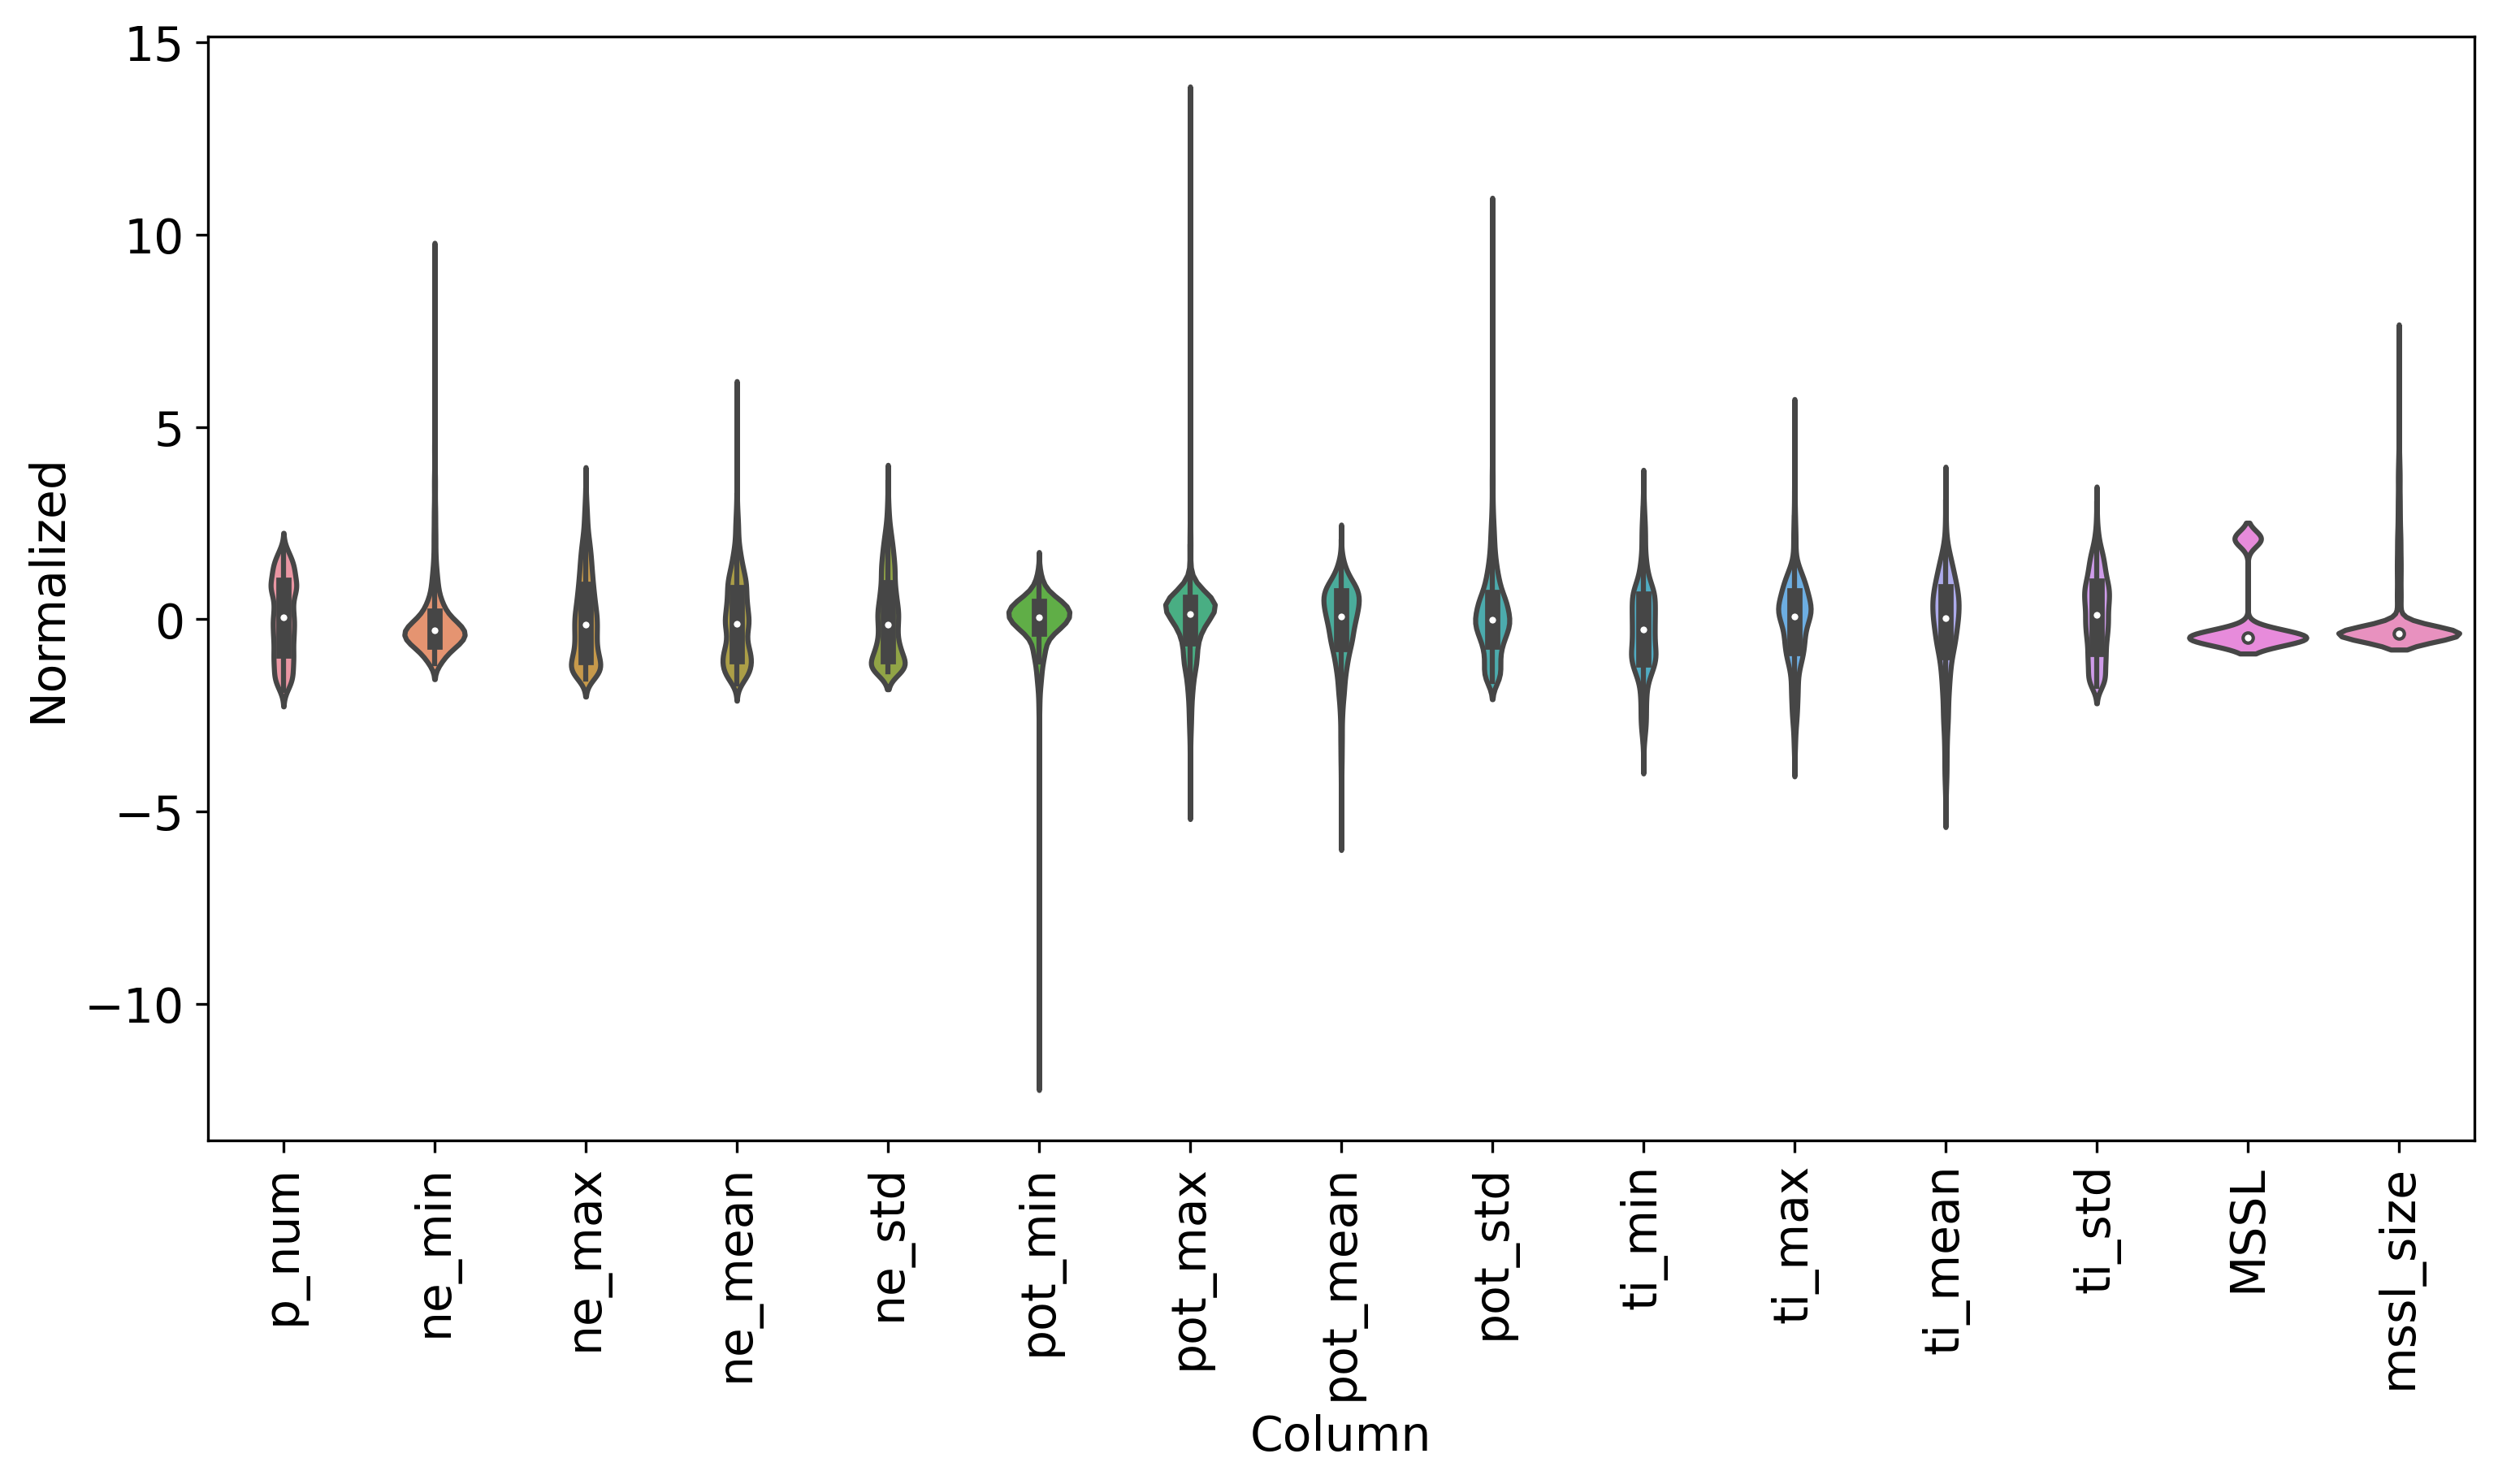

In [ ]:
df_no_date = df_gb.drop(columns=['date'])
df_std = (df_no_date - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

mpl.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6), dpi=300)
ax =sns.violinplot(x=' ', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_no_date.keys(), rotation=90)

KeyboardInterrupt: 

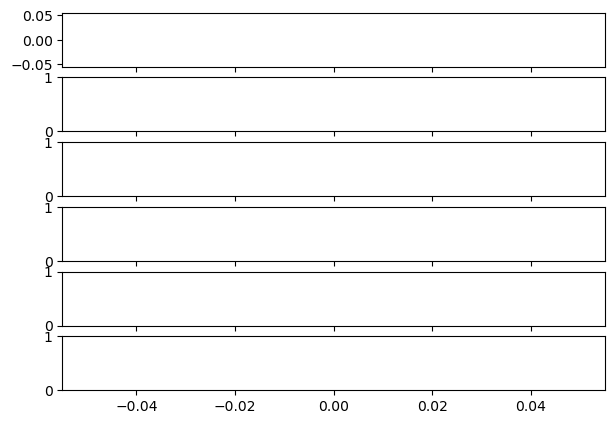

In [152]:
#df = df.iloc[:40]

figs, axs = plt.subplots(ncols=1, nrows=6, figsize=(7,5), 
dpi=100, sharex=True) #3.5 for single, #5.5 for double
axs = axs.flatten()

x = 'p_num'
hue = None

ax0y = 'ne_min'
sns.lineplot(ax = axs[0], data = df, x = x, y =ax0y, 
        palette = 'bone',hue = hue, legend=False)

ax1y = 'ne_max'
sns.lineplot(ax = axs[1], data = df, x =x, y =ax1y,
        palette = 'Set1', hue = hue, legend=False)

ax2y = 'ne_mean'
sns.lineplot(ax = axs[2], data = df, x = x, y =ax2y, 
        palette = 'bone', hue = hue, legend = False)

ax3y = 'ne_std'
sns.lineplot(ax = axs[3], data = df, x = x, y =ax3y, 
        palette = 'Set2', hue = hue, legend = False)

ax3y = 'IBI'
sns.lineplot(ax = axs[4], data = df, x = x, y =ax3y, 
        palette = 'Set2', hue = hue, legend = False)

ax3y = 'MSSL'
sns.lineplot(ax = axs[5], data = df, x = x, y =ax3y, 
        palette = 'Set2', hue = hue, legend = False)

#axs[5].set_xscale('log')


axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')

plt.show()

<Figure size 500x400 with 0 Axes>

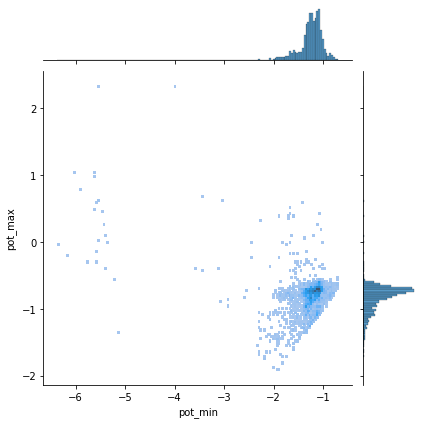

In [132]:
#df = df.iloc[::]
fig = plt.figure(figsize =(5, 4), dpi=100) 
#sns.scatterplot(data = df, x='ne_std', y='pot_std', hue = 'MSSL', alpha=0.8)
#sns.jointplot(data=df, x='pot_min', y='pot_max', kind="hist")
#sns.regplot(data = df, x='ne_max', y='ti_max')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

<AxesSubplot:>

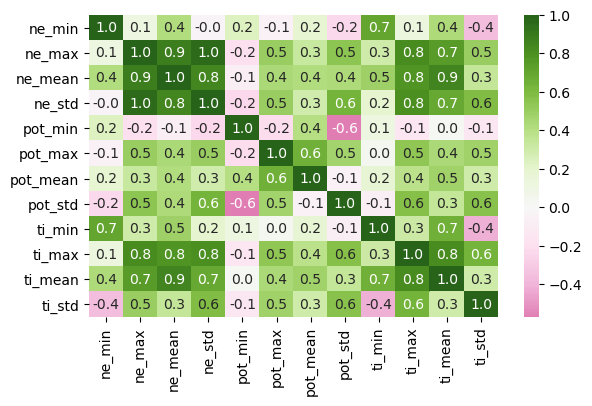

In [153]:
df = df.drop(columns=['date','p_num','IBI','MSSL'])
corr = df.corr()
#print(corr)

corr.style.background_gradient(cmap='coolwarm')
fig = plt.figure(figsize =(6.6, 4), dpi=100) 
sns.heatmap(df.corr(), cmap="PiYG", annot=True, fmt='.1f', center=0)